# Tensorflow Privacy - Satellite Image Example - Privacy Attack and Defence

Here we look at model examples for Membership inference attack and defence, with Differential Privacy using Tensorflow Privacy.

In [1]:
# Set verbosity.
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

# import warnings
# warnings.simplefilter(action="ignore", category=ConvergenceWarning)
# warnings.simplefilter(action="ignore", category=FutureWarning)

import warnings

warnings.filterwarnings('ignore') # get the other details later - not really necessary

In [2]:
import numpy as np
import pandas as pd
from typing import Tuple
from scipy import special
from sklearn import metrics


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2024-04-04 22:36:35.401325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 22:36:35.401399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 22:36:35.447943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 22:36:35.560530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 22:36:37.608665: W tensorflow/compiler/tf2

In [3]:
# tensorflow privacy utils

import tensorflow_privacy

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

In [4]:
dataset = "eurosat/rgb"
num_classes = 10

total_epochs = 10
batch_size = 32

In [5]:
print('Loading the dataset.')
train_ds = tfds.as_numpy(
    tfds.load(dataset, split='train[:80%]', batch_size=-1))
test_ds = tfds.as_numpy(
    tfds.load(dataset, split='train[80%:]', batch_size=-1))
x_train = train_ds['image'].astype('float32') / 255.
y_train_indices = train_ds['label'][:, np.newaxis]
x_test = test_ds['image'].astype('float32') / 255.
y_test_indices = test_ds['label'][:, np.newaxis]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train_indices, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_indices, num_classes)

input_shape = x_train.shape[1:]

assert x_train.shape[0] % batch_size == 0, "The tensorflow_privacy optimizer doesn't handle partial batches"

Loading the dataset.


2024-04-04 22:36:45.655014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 22:36:45.832831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 22:36:45.833218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 22:36:45.836931: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 22:36:45.837430: I external/local_xla/xla/stream_executor

In [6]:
input_shape

(64, 64, 3)

In [7]:
# createa a simple CNN model

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),#ds_info.features['image'].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for eurosat
])



In [8]:
PrivacyReportMetadata

tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures.PrivacyReportMetadata

In [9]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
  def __init__(self, epochs_per_report, model_name):
    self.epochs_per_report = epochs_per_report
    self.model_name = model_name
    self.attack_results = []

  def on_epoch_end(self, epoch, logs=None):
    epoch = epoch+1

    if epoch % self.epochs_per_report != 0:
      return

    print(f'\nRunning privacy report for epoch: {epoch}\n')

    logits_train = self.model.predict(x_train, batch_size=batch_size)
    logits_test = self.model.predict(x_test, batch_size=batch_size)

    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    # Add metadata to generate a privacy report.
    privacy_report_metadata = PrivacyReportMetadata(
        # Show the validation accuracy on the plot
        # It's what you send to train_accuracy that gets plotted.
        accuracy_train=logs['val_accuracy'], 
        accuracy_test=logs['val_accuracy'],
        epoch_num=epoch,
        model_variant_label=self.model_name)

    attack_results = mia.run_attacks(
        AttackInputData(
            labels_train=y_train_indices[:, 0],
            labels_test=y_test_indices[:, 0],
            probs_train=prob_train,
            probs_test=prob_test),
        SlicingSpec(entire_dataset=True, by_class=True),
        attack_types=(AttackType.THRESHOLD_ATTACK,
                      AttackType.LOGISTIC_REGRESSION),
        privacy_report_metadata=privacy_report_metadata)

    self.attack_results.append(attack_results)

In [10]:
# add reports

all_reports = []

# report parameters
epochs_per_report = 2


# combine into a single report later

In [11]:
x_train.shape, y_train.shape, y_test.shape

((21600, 64, 64, 3), (21600, 10), (5400, 10))

In [12]:
# model.compile(
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
# optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
# metrics=['accuracy'])

# improve loss for logit and output could work also - for better accuracy - as seen before, for stability, check that later!!


In [13]:
# combpile and train - # change everything to one format later - after checking that this has worked
callback = PrivacyMetrics(epochs_per_report, "Satellite Regular Model")

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy", #'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True
)

all_reports.extend(callback.attack_results) # everything work - just change the dataset - load to their structure to make it more straight forward after

# depends on approach, go forward - like with kevin or back that's it!!

# train for longer if needed

Epoch 1/10


2024-04-04 22:37:06.784908: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-04 22:37:11.427985: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f13b4f0c5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 22:37:11.428113: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-04 22:37:11.467481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712266631.793542    1054 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


675/675 [==============================] - 25s 19ms/step - loss: 1.3570 - accuracy: 0.4736 - val_loss: 0.9677 - val_accuracy: 0.6444
Epoch 2/10
673/675 [============================>.] - ETA: 0s - loss: 0.9263 - accuracy: 0.6612
Running privacy report for epoch: 2

675/675 [==============================] - 73s 108ms/step - loss: 0.9254 - accuracy: 0.6615 - val_loss: 0.7099 - val_accuracy: 0.7509
Epoch 3/10
675/675 [==============================] - 28s 41ms/step - loss: 0.7617 - accuracy: 0.7284 - val_loss: 0.5761 - val_accuracy: 0.8031
Epoch 4/10
673/675 [============================>.] - ETA: 0s - loss: 0.6436 - accuracy: 0.7715
Running privacy report for epoch: 4

675/675 [==============================] - 75s 111ms/step - loss: 0.6433 - accuracy: 0.7716 - val_loss: 0.5045 - val_accuracy: 0.8296
Epoch 5/10
675/675 [==============================] - 29s 43ms/step - loss: 0.5553 - accuracy: 0.8031 - val_loss: 0.4281 - val_accuracy: 0.8459
Epoch 6/10
674/675 [=========================

169/169 - 4s - loss: 0.3707 - accuracy: 0.8724 - 4s/epoch - 25ms/step

Test accuracy: 0.8724074363708496


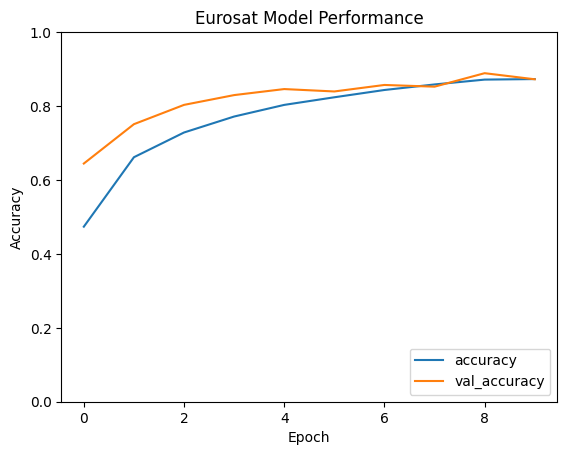

In [14]:
# evaluate training

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Eurosat Model Performance")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}') # maybe add the loss where needed

In [19]:
# to do above, change the code interface for the data in a different workflow, with the same code interface, and that's it
# should work fine otherwise. You're here just to interpret the results that's it!!

# finish the below, that's it
# you need to start with the writing soon!!

## Setup MIA attack and privacy report

Note there is no need to train the model here as before.

**Setup the privacy attack here above also with the report**

Attack during training - review model at each epoch based on different api of the model at different stages of training - could be useful, to review and compare.

In [20]:
# get basic privacy report 

In [21]:
results = AttackResultsCollection(all_reports)

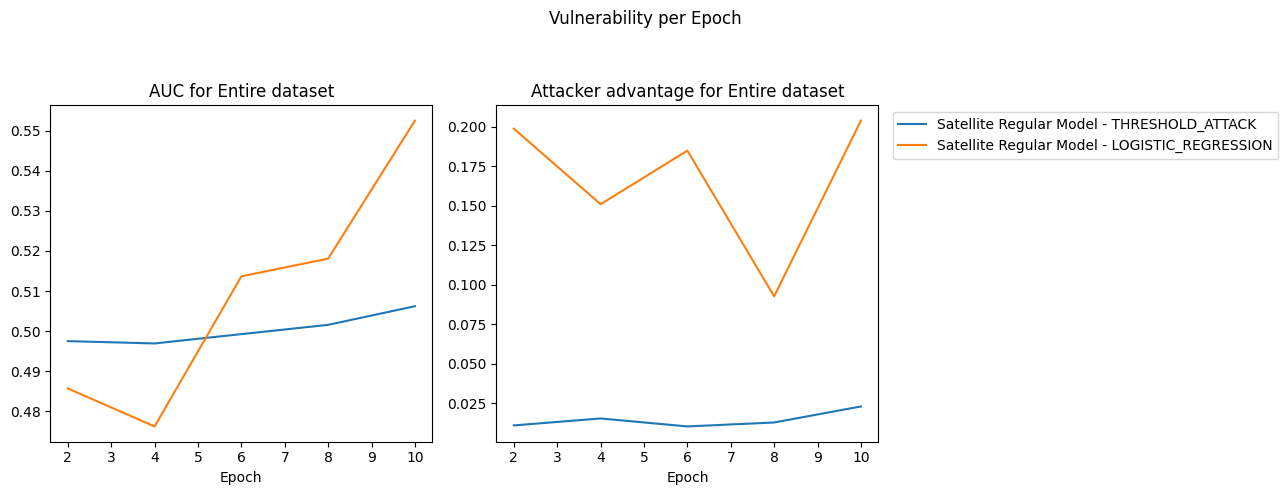

In [22]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results, privacy_metrics=privacy_metrics)

# check interpretation and edit it where necessary
# run code and get everything running here!!

## Train again with Tensorflow privacy

Differential privacy and evaluate epsilon guarantee

In [38]:
x_train.shape

(21600, 64, 64, 3)

In [97]:
# repeat the above with different training, try that idea later!!

# setup training parameters
total_epochs = 10
batch_size = 32

In [100]:
# setup 

l2_norm_clip = 1.7
noise_multiplier = 1.2
num_microbatches = 32 # keeping these the same to test run the approach
# learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [101]:
input_shape

(64, 64, 3)

In [102]:
# setup the same model again but with differential privacy
model_dp = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),#ds_info.features['image'].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for eurosat
])

In [103]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer( 
    # make sure to understand how this works for the assignment
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    # learning_rate=learning_rate
)

In [104]:
# https://github.com/tensorflow/privacy/issues/180

# must set reduction to None here - and define the loss into compile - to make it work with Tensorflow privacy
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)

# don't need this - try the regular version

In [109]:
all_reports2 = []

In [105]:
callback = PrivacyMetrics(epochs_per_report, "Satellite Model With Differential Privacy")

model_dp.compile(
    optimizer=optimizer,
    loss=loss, # "categorical_crossentropy", #'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model_dp.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True
) # gpu memory too big, so make a smaller batch size and it is working - remember the idea of batch sizes here!!

Epoch 1/10
675/675 [==============================] - 98s 139ms/step - loss: 2.2208 - accuracy: 0.2055 - val_loss: 2.0519 - val_accuracy: 0.2557
Epoch 2/10
675/675 [==============================] - ETA: 0s - loss: 1.9487 - accuracy: 0.2393
Running privacy report for epoch: 2

675/675 [==============================] - 119s 177ms/step - loss: 1.9487 - accuracy: 0.2393 - val_loss: 1.7966 - val_accuracy: 0.2896
Epoch 3/10
675/675 [==============================] - 88s 130ms/step - loss: 1.8850 - accuracy: 0.2561 - val_loss: 1.7669 - val_accuracy: 0.2924
Epoch 4/10
675/675 [==============================] - ETA: 0s - loss: 1.8873 - accuracy: 0.2546
Running privacy report for epoch: 4

675/675 [==============================] - 111s 165ms/step - loss: 1.8873 - accuracy: 0.2546 - val_loss: 1.7749 - val_accuracy: 0.2478
Epoch 5/10
675/675 [==============================] - 86s 126ms/step - loss: 1.8743 - accuracy: 0.2609 - val_loss: 1.7286 - val_accuracy: 0.3117
Epoch 6/10
675/675 [=========

In [110]:
all_reports2.extend(callback.attack_results)

We see that model performance significantly impacted, and model requires longer training for the workflow.

Moreover, we would need a model to process a bigger batch size, and higher capacity for us to gain better performance from the noise that is added to our data.

Essentially working in a higher noise enovironment - hence we need to get the model to work harder to work in this noisy environment.

Describe write up for the workflow here, and that's it - try to add other details here where needed. Just describe the trade off rather than the exact performance

169/169 - 2s - loss: 0.3707 - accuracy: 0.8724 - 2s/epoch - 11ms/step

Test accuracy: 0.8724074363708496


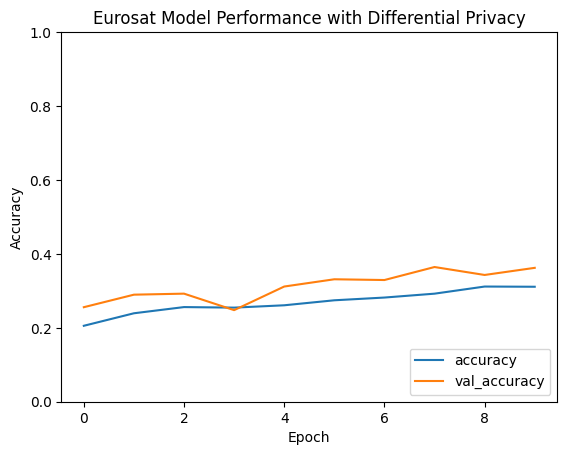

In [106]:
# evaluate training

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Eurosat Model Performance with Differential Privacy")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}') # maybe add the loss where needed

## Setup MIA attack and privacy report (for model with differential privacy)

In [ ]:
# 1. measure mia attack

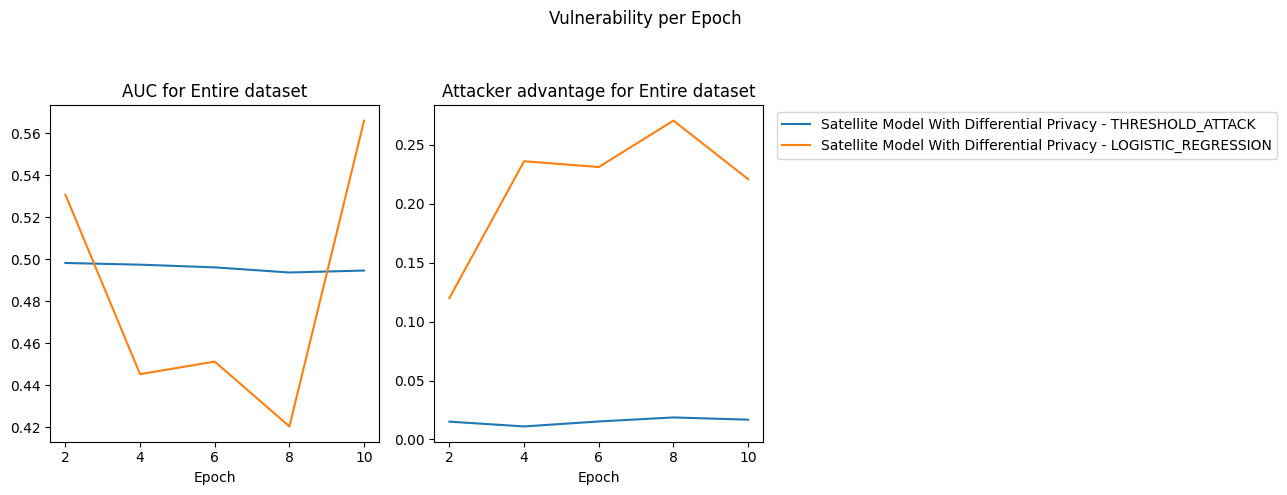

In [111]:
results2 = AttackResultsCollection(all_reports2)

privacy_metrics2 = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot2 = privacy_report.plot_by_epochs(
    results2, privacy_metrics=privacy_metrics2)

In [ ]:
# 2. review the attack - evaluate privacy report

In [112]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

In [116]:
x_train.shape, total_epochs

((21600, 64, 64, 3), 10)

In [118]:
print(compute_dp_sgd_privacy.compute_dp_sgd_privacy_statement(
    number_of_examples = x_train.shape[0],
    batch_size=batch_size,
    num_epochs = total_epochs,
    noise_multiplier=noise_multiplier,
    delta=0.01 # choose delta like a confidence bound #1e-5
)) # very high privacy - issues - check issues, over these values # discuss what the delta value here

DP-SGD performed over 21600 examples with 32 examples per iteration, noise
multiplier 1.2 for 10 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 0.01 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        28.133
    Epsilon assuming Poisson sampling (*):                      1.480

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed the actual epsilon should be
closer to this value than the conservative assumption of an arbitrary data
order.



Delta (δ) is a parameter in the (ε, δ)-differential privacy definition that represents the probability of the privacy guarantee not holding. In simpler terms, it quantifies the risk that the privacy protection might fail.

### Other ideas

Suggest other datasets to work from. And more sophisticated approaches, for getting it working.

Suggest how attacks can be combined together, try some simple approaches later, to combine attack details. Try combining it again in the evening - but that's it!!

But finish the initial write up first, and then combine it afterwards.


In [1]:
# check with g on this with different models.

Justification of benchmark data, ideas - with transferable skills, to avoid using real world data - and competition etc.

Moreover describe how they are transferable and that's it!!

Save and load the model here for what you need. So as to save time from training everytime!!

Writing ideas

It is about the interpretation of the parameters rather than everything in the above!!

So here we have what we need in the above!